# Argon clean!!

In [1]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
import statistics as stats
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from numba import jit

import timeit
%matplotlib inline

import init
from force import Forces
from Forcesg import Forcesg

# General constants

In [2]:
#preferrably unvariable
L = 3 #number of unit cells in 3 directions
Z = 4 #number of atoms per unit cell
N = Z*L**3 #number of atoms in total space


## input parameters , for controlling the phase 
rho = 0.7 #density of particles
T = 1.0

## parameters that are influenced by input parameters
l = (Z/rho)**(1/3) #unit cell length in sigma
ld = L*l #computational domain length


# Constant Energy verification

In [ ]:
r=init.position(l,N,L)
v=init.velocity(T,N)
F,V=Forces(r, ld, N)

Time = 250 #timesteps
dt = 0.004 #length of timestep

#initiate vectors
K=np.zeros(shape=(Time,))
Energy=np.zeros(shape=(Time,))
Ve = np.zeros(shape=(Time, ))

for i in range(Time):
    ## Verlet algorithm
    v += 0.5* F * dt #halfway step for velocity (verlet)
    r += v * dt #update position
    r = np.mod(r , (ld)) #periodic boundary
    F,V = Forces(r,ld,N) #forces due to new position
    v += 0.5 * F * dt #complete velocity step
    v2 = np.multiply(v,v)
    
    #Calculate energies
    K[i] = 0.5*np.sum(v2) #kinetic energy
    Ve[i]=V #potential
    Energy[i]=K[i]+Ve[i] #total

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Energy,label='Total')
ax.plot(Ve,label='Potential')
ax.plot(K,label='Kinetic')
plt.legend(loc=0)
# a = plt.plot(Energy, label='Energy')
# b = plt.plot(Ve, label='Potential Energy')
# c = plt.plot(K, label='Kinetics Energy')
# plt.legend(handles=[a,b,c])



    


# Determination of Averages

Scaling of the velocities for a desired temperature

In [ ]:
Time = 1000 #amount of timesteps for Cv calculation
lt = 200 #amount of timesteps to thermostate

#initiate atoms
r=init.position(l,N,L)
v=init.velocity(T,N)
F,V=Forces(r, ld, N)

#initiate vectors 
K=np.zeros(shape=(Time,))
Energy = np.zeros(shape=(Time,))

for i in range(Time):
    ## Verlet Algorithm
    v += 0.5* F * dt #halfway step for velocity (verlet)
    r += v * dt #update position
    r = np.mod(r , (ld)) #periodic boundary
    F,V = Forces(r,ld,N) #forces due to new position
    v += 0.5 * F * dt #complete velocity step
    
    #Thermostat
    K[i] = 0.5*np.sum( v * v)
    if i<lt and (np.mod(i,10)==0): #mod for calling thermostat every 10 timesteps
        #thermostat
        scale=math.sqrt(1.5*(N-1)*T/K[i]) 
        v=scale*v
        
    #Energy to calculate Cv
    K[i] = 0.5*np.sum( v * v)
    Energy[i] = K[i] + V        
   

 ## Heat Capacity 



In [ ]:
# Get kinetic energy only after equilibrium (so after thermostat is done)
Knew = K[lt:]
#print(Knew)
Kmean = np.mean(Knew)
Kmean2 = Kmean*Kmean 
Kvar = np.var(Knew)
Cv = (3*Kmean2)/(2*Kmean2 - 3*N*Kvar) # Cv /N (to check Cv/N = 1.5 kb )
print("Cv is", Cv)

# visual check to see if energy is really constant
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(Energy,label='Total')
plt.plot(K,label='Kinetic')
plt.legend(loc=0)

# Correlation function

In [6]:
Time = 5000 #amount of timesteps for correlation function calculation
lt = 2500 #amount of thermostat timesteps
dt = 0.004 #length of timestep

# constants for creating histogram
bins=50
binlen=ld/bins
#initiate atoms
r=init.position(l,N,L)
v=init.velocity(T,N)
F,n,notforce=Forcesg(r, ld, N, bins, binlen)

for i in range(Time):
    ## Verlet Algorithm
    v += 0.5* F * dt #halfway step for velocity (verlet)
    r += v * dt #update position
    r = np.mod(r , (ld)) #periodic boundary
    F , nt, notforce = Forcesg(r,ld,N,bins,binlen) #forces due to new position
    v += 0.5 * F * dt #complete velocity step
    if i>lt: #start counting distances after thermostat is done
        n += nt
    if i<lt and (np.mod(i,15)==0): #mod for calling thermostat every 20 timesteps
        #thermostat
        K = 0.5*np.sum( v * v)
        scale=math.sqrt(1.5*(N-1)*T/K)
        v=scale*v
    
navg=n/(Time-lt) #time averaging

for j in range(bins):
    Vshell=4*math.pi*(((j+0.5)*binlen)**2)*binlen #using r = (i+0.5)*dr for "average" distance for bin, 
    #computing the volume of the shell
    navg[j]=navg[j]/Vshell
    
corr=2*ld**3/(N*(N-1))*navg #correlation function
xaxis = np.linspace(0,ld,bins) #xaxis for correlation function

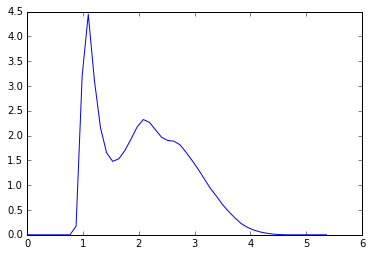

In [8]:
#Plotting of the correlation function
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(xaxis,corr)

## Pressure


In [10]:
Time = 5000 #amount of timesteps for Cv calculation
lt = 2500 #amount of timesteps to thermostate
dt = 0.004 #length of timestep

#initiate atoms
r=init.position(l,N,L)
v=init.velocity(T,N)
F, nt, pressuret = Forcesg(r, ld, N,1,ld)


## MOOT variables
bins = 1
binlen = ld

#initiate vectors 
pressure = pressuret

for i in range(Time):
    ## Verlet Algorithm
    v += 0.5* F * dt #halfway step for velocity (verlet)
    r += v * dt #update position
    r = np.mod(r , (ld)) #periodic boundary
    F,nt,pressuret = Forcesg(r,ld,N,bins,binlen) #forces due to new position
    v += 0.5 * F * dt #complete velocity step
    
    #Thermostat
    if i<lt and (np.mod(i,10)==0): #mod for calling thermostat 10 times in time lt
        K = 0.5*np.sum( v * v)
        scale=math.sqrt(1.5*(N-1)*T/K)
        v=scale*v
    else: 
        #Only do pressure when not using thermostat
        pressure += pressuret  
    
P = 1 - 1/(6*N*T) * pressure/((Time-lt)) - 2*math.pi*N/(3*T*(ld**3)) * 0.1223766835
print(P)

0.5172698160694551


## Hoi Mitchel

In [9]:
Time = 5000 #amount of timesteps for Cv calculation
lt = 2500 #amount of timesteps to thermostate
dt = 0.004 #length of timestep

#initiate atoms
r=init.position(l,N,L)
v=init.velocity(T,N)
F, nt, pressuret = Forcesg(r, ld, N,1,ld)


## MOOT variables
bins = 1
binlen = ld

#initiate vectors 
pressure = pressuret

for i in range(Time):
    ## Verlet Algorithm
    v += 0.5* F * dt #halfway step for velocity (verlet)
    r += v * dt #update position
    r = np.mod(r , (ld)) #periodic boundary
    F,nt,pressuret = Forcesg(r,ld,N,bins,binlen) #forces due to new position
    v += 0.5 * F * dt #complete velocity step
    
    #Thermostat
    if i<lt and (np.mod(i,10)==0): #mod for calling thermostat 10 times in time lt
        K = 0.5*np.sum( v * v)
        scale=math.sqrt(1.5*(N-1)*T/K)
        v=scale*v
    else: 
        #Only do pressure when not using thermostat
        pressure += pressuret  
    
P = 1 - 1/(3*N*T) * pressure/((Time-lt)) - 2*math.pi*N/(3*T*(ld**3)) * 0.510601
print(P)

-0.0654751241552749
